In [2]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv('kc_house_data.csv')

### Waterfront - Missing values investigation

Most missing values have prices on the lower end. We might want to fill in with a 0 value, meaning waterfront since non-waterfront properties will be lower than those with waterfront. But this might also be a general reflection of the data.

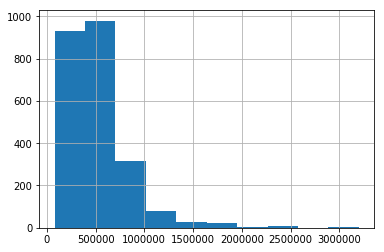

In [6]:
df[df['waterfront'].isna() == True].price.hist()

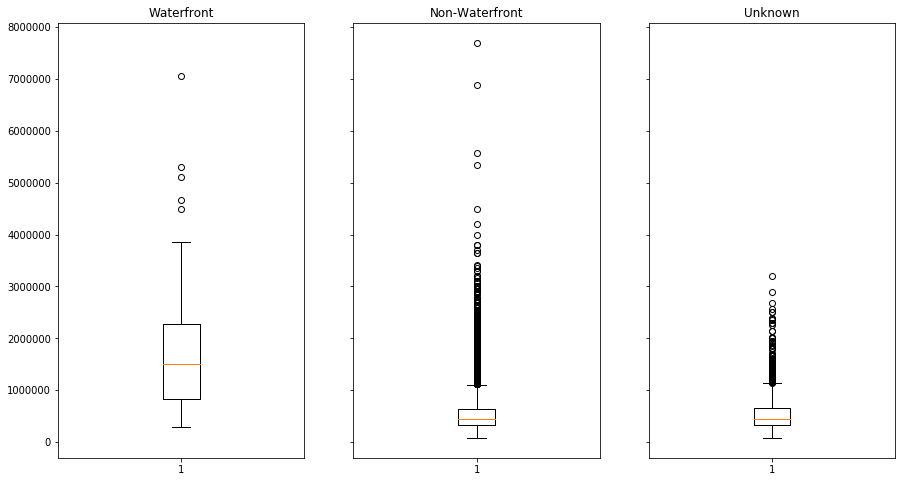

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey='row')
axes[0].boxplot(df[df['waterfront'] == 1.0].price)
axes[0].set_title("Waterfront")
axes[1].boxplot(df[df['waterfront'] == 0.0].price)
axes[1].set_title("Non-Waterfront")
axes[2].boxplot(df[df['waterfront'].isna() == True].price)
axes[2].set_title("Unknown")
#plt.xticks(rotation='vertical')
plt.show()

Comparing distributions - the missing values has a median and quartile distribution similar to the non-waterfront properties (above). Below, we can see that the minimum missing value group is similar to the non-waterfront properties, however non-waterfront properties has maxes in the 7 million range similar to non-waterfront. So maximum value won't help much.

In [8]:
print(int(df[df['waterfront'] == 1.0].price.mean()))
print(int(df[df['waterfront'] == 1.0].price.median()))
print(int(df[df['waterfront'] == 0.0].price.mean()))
print(int(df[df['waterfront'] == 0.0].price.median()))
print(int(df[df['waterfront'].isna() == True].price.mean()))
print(int(df[df['waterfront'].isna() == True].price.median()))

1717214
1510000
532641
450000
529430
445000


In [59]:
print(df[df['waterfront'] == 1.0].price.max())
print(df[df['waterfront'] == 1.0].price.min())
print(df[df['waterfront'] == 0.0].price.max())
print(df[df['waterfront'] == 0.0].price.min())
print(df[df['waterfront'].isna() == True].price.max())
print(df[df['waterfront'].isna() == True].price.min())

7060000.0
285000.0
7700000.0
78000.0
3200000.0
80000.0


There are many more non-waterfront properties (99%) than waterfront (0.7%).

In [61]:
df['waterfront'].value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [11]:
prob_dist = df.waterfront.value_counts(normalize=True)
print(prob_dist)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64


Nevertheless, just to be sure we can random choice selectiong based on the distribution. 99% in the non-waterfront means that most of them will be assigned non-waterfront status.

In [12]:
missing = df['waterfront'].isnull()
df.loc[missing,'waterfront'] = np.random.choice(prob_dist.index, size=len(df[missing]),p=prob_dist.values)
df[df['waterfront'].isna() == True]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [14]:
df['waterfront'].value_counts(normalize=True)

0.0    0.992638
1.0    0.007362
Name: waterfront, dtype: float64

We didn't end up changing the distribution too much.

## Zipcodes

Zipcode search shows that we have a min/max zip code of Sammamish to Lake City in Seattle.

https://www.google.com/search?q=zipcode+98125&oq=zi&aqs=chrome.0.69i59j0j69i59j69i57j0l2.1053j0j7&sourceid=chrome&ie=UTF-8

https://www.google.com/search?q=zipcode+98074&oq=z&aqs=chrome.2.69i60j69i59l2j69i57j69i60j69i61.2073j0j9&sourceid=chrome&ie=UTF-8

Zipcodes are fairly large, for example my zipcode, 98144, extends all the way to the waterfront. The houses on and near the waterfront are very nice and highly desirable. On the west side, it's a very busy thoroughfare and a transitional neighborhood. I would think that zipcode as a location feature wouldn't be fine grained enough to represent neighborhood desirability. For this reason, after doing two rounds of modeling, I thought to use lat-long to create bins mimicing a smaller zone of neighbhorhoods. (See below)

<img src="zipcodes.jpg">

### Lat / Long investigation and binning

Here I look at the lat-long distributions to get an idea of the data and find some errors most likely, and try to find how much change in lat long would make a difference in terms of delineating a new neighborhood.

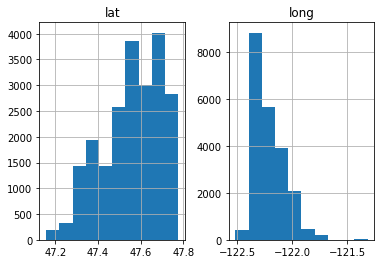

In [66]:
df[['lat', 'long']].hist();

There seems to be some outliers in the longitude feature - it looks as though there's a jump to -121.5.

Let's find the row with the max longitude, to see if anything jumps out, as well as look at the latitude to pinpoint this location

In [67]:
df['long'].max()

-121.315

In [68]:
df.loc[df['long'].idxmax()].lat

47.713

In [69]:
df.loc[df['long'].idxmax()]

id               8649401270
date              4/30/2015
price                167000
bedrooms                  1
bathrooms                 1
sqft_living             780
sqft_lot              10235
floors                  1.5
waterfront                0
view                      0
condition                 3
grade                     6
sqft_above              780
sqft_basement           0.0
yr_built               1989
yr_renovated            NaN
zipcode               98014
lat                  47.713
long               -121.315
sqft_living15           930
sqft_lot15            10165
Name: 2925, dtype: object

Location based on coordinates takes us to Skykomish which has a zipcode of 98288.
https://www.google.com/maps/place/47%C2%B042'46.8%22N+121%C2%B018'54.0%22W/@47.7134582,-121.8753472,9z/data=!4m5!3m4!1s0x0:0x0!8m2!3d47.713!4d-121.315


Looking up the zipcode listed in that row shows Carnation:
https://www.google.com/maps/place/Carnation,+WA+98014/@47.6595647,-122.0321526,11z/data=!3m1!4b1!4m5!3m4!1s0x54907427337254bf:0x9a99e3b770b617f2!8m2!3d47.6478606!4d-121.9140287

Let's zoom in on not just the max longitude but all those outliers

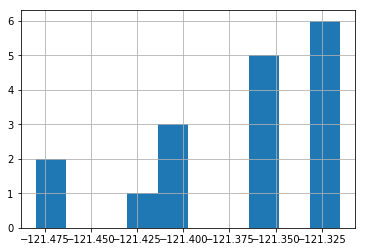

In [73]:
df.loc[df['long'] > -121.5].long.hist();

Now we get the zipcodes for all of these cases

In [18]:
df.loc[df['long'] > -121.5].zipcode.value_counts()

98014    14
98019     2
98045     1
Name: zipcode, dtype: int64

In [19]:
df[ ((df['zipcode'] == 98045) | (df['zipcode'] == 98014) | (df['zipcode'] == 98019))
   & (df['long'] > -121.5)].head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2587,5061300030,5/8/2014,134000.0,2,1.50,980,5000,2.0,0.0,0.0,...,7,980,0.0,1922,2003.0,98014,47.7076,-121.359,1040,5000
2925,8649401270,4/30/2015,167000.0,1,1.00,780,10235,1.5,0.0,0.0,...,6,780,0.0,1989,NaN,98014,47.7130,-121.315,930,10165
4199,1437500015,7/9/2014,150000.0,3,0.75,490,38500,1.5,0.0,0.0,...,5,490,0.0,1959,0.0,98014,47.7112,-121.315,800,18297
4844,192300020,5/21/2014,525000.0,3,2.75,2100,10362,2.0,0.0,0.0,...,9,1510,590.0,1998,0.0,98045,47.4347,-121.417,2240,11842
5861,7349800780,8/5/2014,175000.0,2,1.75,1050,9800,1.5,0.0,0.0,...,6,1050,0.0,1975,0.0,98019,47.7595,-121.473,1230,12726


https://www.google.com/maps/place/47%C2%B045'34.2%22N+121%C2%B028'22.8%22W/@47.7596172,-121.7531666,10z/data=!4m5!3m4!1s0x0:0x0!8m2!3d47.7595!4d-121.473

https://www.google.com/maps/place/47%C2%B042'27.4%22N+121%C2%B021'32.4%22W/@47.7076036,-121.361194,17z/data=!3m1!4b1!4m5!3m4!1s0x0:0x0!8m2!3d47.7076!4d-121.359

These all seem to be incorrect

Only a subset of those with zipcode 98014 seem to be correct. It looks to be about 0.4-0.6 off.

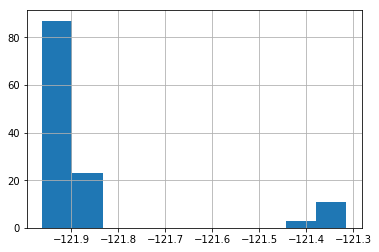

In [21]:
df.long[ (df['zipcode'] == 98014)].hist();

In [22]:
fix = df.index[(df['zipcode'] == 98014) & (df['long'] > -121.7)].tolist()

Let's add about 0.6 to the longitude to get it in the right range

In [23]:
df.loc[fix,'long'] = df.loc[fix].long - 0.6

The histogram for those with zipcode 98014 looks more reasonable now.

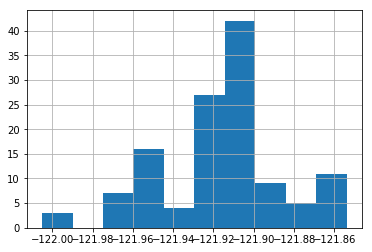

In [24]:
df.long[ (df['zipcode'] == 98014)].hist();

As does the general data.

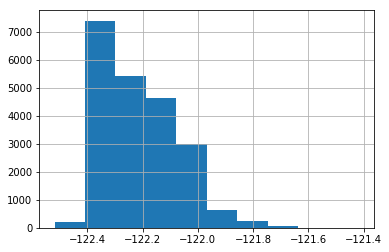

In [25]:
df.long.hist();

#### Lat / Long Binning

What is the appropriate bin size for Lat/Long? 

Going east of my house, where I know is a slightly nicer neighborhood has a difference of ~ 0.010. Similarly, going north there is a difference of ~0.010. Other neighborhoods do not have such micro-differences in terms of desirability. Queen Anne has a larger area, and from east to west has a difference of ~0.030. I'll take the average and use 0.020 as a bin sizes.

In [26]:
df['long'].max(), df['long'].min()

(-121.417, -122.51899999999999)

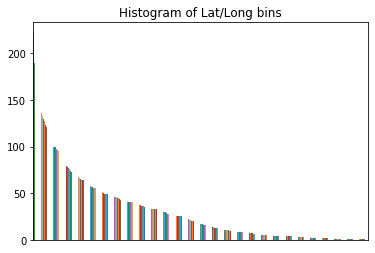

In [27]:
#find bins
long_bins = np.arange(df['long'].min(), df['long'].max() + 0.1 , 0.020)
lat_bins = np.arange(df['lat'].min(), df['lat'].max() + 0.1, 0.020)
#basement['binned'] = pd.cut(basement['sqft_basement'], bins, include_lowest =True)
df['long_bin'] = pd.cut(df['long'], long_bins, include_lowest =True)
df['lat_bin'] = pd.cut(df['lat'], lat_bins, include_lowest =True)

#combine lat/long bin as if str category
df['latlong_zone'] = df['long_bin'].astype('str') + df['lat_bin'].astype('str')

df['latlong_zone'].value_counts().plot(kind='bar')
plt.gca().axes.get_xaxis().set_visible(False)
plt.title('Histogram of Lat/Long bins')
plt.show();

In [28]:
df['latlong_zone'].nunique()

697

Unfortunately, this created 697 zones! When we treat these as categories, and turn them into one-hot vectors we'll end up with an additional 697 features. When training a stepwise model, it ran too slowly to be effective (that's at least 697! combinations!!!). I played around with the size of the bin, up to 0.3, however the fewest number of features created was still around 400. I decided to abandon this approach. It might work with deep neural net trained on GPUs, but for linear regression it just isn't appropriate.


I do end up using lat/long as numerical features, but - spoiler alert - it doesn't improve over the best model

In [ ]:
def lat_long_features(df):
    df = pd.get_dummies(df, columns=['latlong_zone'], prefix=["ll_zone"])
    return df

### Sq Ft Basement investigation

Square feet of basement has missing values in the form of a string ?. Seattle is quite hilly, and difficult to say what counts as basement or not. The bottom floor may be underground on one side and the other open up to a backyard. Somtimes, assessors or realtors label things weirdly. My house is 3 stories but most of the living area is the 2nd and 3rd floor and the assessor called the first floor the basement and the rest as living area. Given these issues, I'll use binning and probability distributions of those bins to randomly choose a bin and then fill with the mean value in that bin.

/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


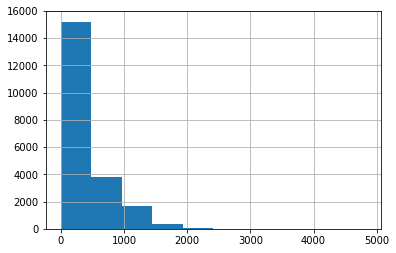

In [29]:
basement = df[df['sqft_basement'] != '?']
basement['sqft_basement'] = basement['sqft_basement'].astype('float')
basement['sqft_basement'].hist()

In [30]:
np.random.seed(42)
print(len(basement[ basement['sqft_basement'] == 0.0]) / len(basement))

print(len(basement[ basement['sqft_basement'] <= 500]) / len(basement))

bins = [0, 1, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4500, 5000]
basement['binned'] = pd.cut(basement['sqft_basement'], bins, include_lowest =True)

print(basement['binned'].value_counts())
bin_mean = basement.groupby('binned').sqft_basement.mean()
round(bin_mean[bin_mean.index.values[0]], 1)

0.6066310362767819
0.7308328997777042
(-0.001, 1.0]       12826
(500.0, 1000.0]      3865
(1.0, 500.0]         2626
(1000.0, 1500.0]     1481
(1500.0, 2000.0]      270
(2000.0, 2500.0]       59
(2500.0, 3000.0]       11
(3000.0, 3500.0]        3
(4500.0, 5000.0]        1
(3500.0, 4500.0]        1
Name: binned, dtype: int64


/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


0.0

In [31]:
# do binning
bin_labels = basement['binned'].value_counts().index.values.tolist()
# assign category

prob_sum_one = [i/sum(basement['binned'].value_counts()) for i in basement['binned'].value_counts()]
def compute_class(value):
    if value == '?':
        interval_assignment = np.random.choice(bin_labels, p=prob_sum_one)
        return round(bin_mean[interval_assignment], 1)
    else:
        return float(value)
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: compute_class(x))

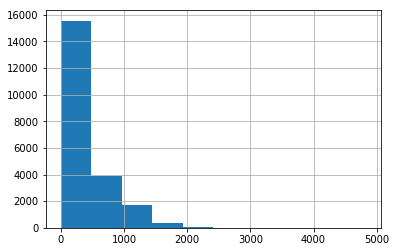

In [32]:
df['sqft_basement'].hist();

Let's investigate some outliers.

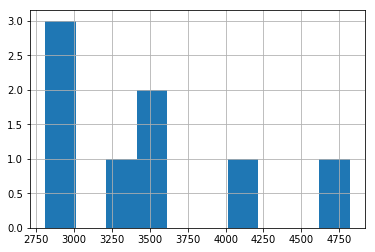

In [113]:
df.sqft_basement[df['sqft_basement'] > 2750].hist();

These basements are larger than some houses! Looking at the price of these houses, they are 1.5 million dollars and above. So we can say it might be reasonable to have a basement that large for some luxury houses.

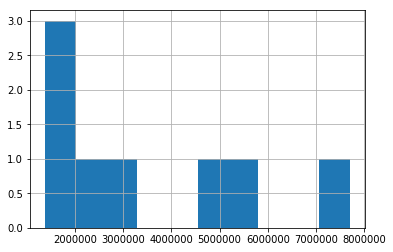

In [114]:
df.price[df['sqft_basement'] > 2750].hist();

Unfortunately, when tranforming the data basement couldn't be transformed into a normal distribution and was dropped.